# Binary Neural Network Classification with Multi-layer Perceptrons
## Krishna Thiyagarajan
## ECE - 411 - Computational Graphs for Machine Learning
## Professor Chris Curro
## Homework Assignment #2
## February 6, 2017

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from IPython.core.display import HTML

warnings.filterwarnings('ignore')

# Hyper Parameters

rateLearn = 1e-3
runs = 200
regConst = 1e-5
displaySteps = 20

noiseSigma = 0.03

totalSamples = 1000
percentTrain = 0.75

numSamp = totalSamples * percentTrain
numTest = totalSamples * (1 - percentTrain)

layers = [2, 20, 40, 20, 2]

In [2]:
# Data generation function

def data(n):
    t = np.random.uniform(low=0.0, high=2 * np.pi, size=n)
    c = np.random.randint(0, high=2, size=n)
    x = t * np.cos(t + c * np.pi) + np.random.normal(0, noiseSigma, n)
    y = t * np.sin(t + c * np.pi) + np.random.normal(0, noiseSigma, n)
    return x, y, c


# Function to help declaring variables in model

def defVar(shape, name):
    var = tf.get_variable(name=name,
                          dtype=tf.float32,
                          shape=shape,
                          initializer=tf.random_normal_initializer())
    tf.add_to_collection('modelVars', var)
    tf.add_to_collection('l2', tf.reduce_sum(tf.square(var)))
    return var


# Multi-layer perceptron model with variable layers and neurons

class MultiLayerPercepModel:
    def __init__(self, sess, layers, iterations, learnRate, gamma):
        self.sess = sess
        self.iterations = iterations
        self.learnRate = learnRate
        self.gamma = gamma
        self.layers = layers
        self.buildModel()

    # Build yhat and loss function

    def buildModel(self):
        self.x = tf.placeholder(tf.float32, [None, self.layers[0]])
        self.y = tf.placeholder(tf.float32, [None, self.layers[-1]])

        self.weights = {}
        self.biases = {}

        for ii in range(0, len(self.layers) - 1):
            self.weights[ii] = defVar(name='w%d' % ii, shape=[self.layers[ii], self.layers[ii + 1]])
            self.biases[ii] = defVar(name='b%d' % ii, shape=[self.layers[ii + 1]])

        self.yhat = tf.nn.relu(tf.add(tf.matmul(self.x, self.weights[0]), self.biases[0]))

        for ii in range(1, len(self.layers) - 1):
            self.yhat = tf.nn.relu(tf.add(tf.matmul(self.yhat, self.weights[ii]), self.biases[ii]))

        self.yhat = tf.nn.softmax(self.yhat)

        self.costs = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.yhat, labels=self.y))
        self.l2 = tf.reduce_sum(tf.get_collection('l2'))
        self.loss = self.costs + self.gamma * self.l2

    def initTrainer(self):
        modelVars = tf.get_collection('modelVars')
        self.optim = (tf.train.AdamOptimizer(learning_rate=self.learnRate).minimize(self.loss, var_list=modelVars))
        self.sess.run(tf.global_variables_initializer())

    def iterateTrainer(self, x, y):
        _, loss = self.sess.run([self.optim, self.loss], feed_dict={self.x: np.transpose(np.asarray(x)), self.y: y})
        return loss

    def train(self, xSamp, ySamp, cSamp):
        for step in range(self.iterations + 1):
            avgCost = 0
            for x, y, c in zip(xSamp, ySamp, cSamp):
                inputs = np.expand_dims(np.asarray([x, y]), axis=1)
                outputs = np.reshape([float(1 - c), float(c)], (1, 2))
                avgCost += self.iterateTrainer(inputs, outputs) / len(xSamp)
            if step % displaySteps == 0:
                print("Step: {:4d}, Loss: {:.9f}".format(step, avgCost))

    # Finds probability that given a point x and y, it's from curve with class 1
    def inferProb(self, x1, y1):
        temp = np.expand_dims(np.asarray([x1, y1]), axis=1)
        return self.sess.run(self.yhat, feed_dict={self.x: np.transpose(temp)})[0][1]

    # Infers class from probability function
    def inferClass(self, x1, y1):
        return self.inferProb(x1, y1) > 0.5

In [3]:
xSamp, ySamp, cSamp = data(numSamp)
xTest, yTest, cTest = data(numTest)

sess = tf.Session()

model = MultiLayerPercepModel(sess=sess, layers=layers, iterations=runs, learnRate=rateLearn, gamma=regConst)
model.initTrainer()
model.train(xSamp, ySamp, cSamp)

infer = np.array([])

for x, y, _ in zip(xTest, yTest, cTest):
    infer = np.append(infer, model.inferClass(x, y))

# Thanks to Sahil Patel for hinting me towards contours
domain = np.arange(-7, 7, 0.1)
xCont, yCont = np.meshgrid(domain, domain)
prob = np.vectorize(model.inferProb)
zCont = prob(xCont, yCont)

accuracy = np.sum(np.equal(cTest, infer)) * 100 / numTest

print("Accuracy: {}%".format(accuracy))

Step:    0, Loss: 0.687872671
Step:   20, Loss: 0.578806470
Step:   40, Loss: 0.324198207
Step:   60, Loss: 0.321145948
Step:   80, Loss: 0.319992161
Step:  100, Loss: 0.321819115
Step:  120, Loss: 0.318569587
Step:  140, Loss: 0.318101752
Step:  160, Loss: 0.330835138
Step:  180, Loss: 0.317184813
Step:  200, Loss: 0.317857875
Accuracy: 100.0%


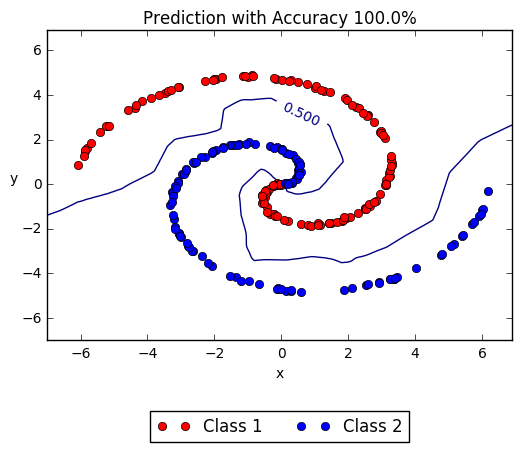

In [4]:
plt.figure()
bound = plt.contour(xCont, yCont, zCont, levels=[0.5])
plt.clabel(bound, inline=1, fontsize=10)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Prediction with Accuracy {}%'.format(accuracy))
plt.plot(xTest[infer == True], yTest[infer == True], 'ro', label='Class 1')
plt.plot(xTest[infer == False], yTest[infer == False], 'bo', label='Class 2')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

## Sample Previous Runs

In [5]:
Image(url= "./figure_1.png")

In [6]:
Image(url= "./figure_2.png")

In [7]:
Image(url= "./figure_3.png")

In [8]:
Image(url= "./figure_4.png")

In [9]:
Image(url= "./figure_5.png")